In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [23]:
from transformers import BertTokenizer, LxmertTokenizer
from data import ImageTextClassificationDataset, collate_fn_batch_visualbert, collate_fn_batch_lxmert, collate_fn_batch_visualbert_semi_supervised, collate_fn_batch_lxmert_semi_supervised
from matplotlib import pyplot as plt
import pandas as pd
from functools import partial
import torch
import os
import numpy as np
import cv2 as cv

In [3]:
# import argparse

In [3]:
# parser = argparse.ArgumentParser(description='train')
parser = pd.Series()
parser = parser.append(pd.Series({'img_feature_path': "../data/features/visualgenome/"}))
parser = parser.append(pd.Series({'train_csv_path': "../data/splits/random/memotion_train.csv"}))
parser = parser.append(pd.Series({'val_csv_path': "../data/splits/random/memotion_val.csv"}))
parser = parser.append(pd.Series({'model_type': "visualbert"}))
parser = parser.append(pd.Series({'model_path': "uclanlp/visualbert-vqa-coco-pre"}))
parser = parser.append(pd.Series({'learning_rate': 2e-5}))
parser = parser.append(pd.Series({'epoch': 100}))
parser = parser.append(pd.Series({'eval_step': 100}))
parser = parser.append(pd.Series({'batch_size': 8}))
parser = parser.append(pd.Series({'amp':True}))
parser = parser.append(pd.Series({'output_dir': "./tmp"}))
parser = parser.append(pd.Series({'checkpoint_step': 1000}))
parser = parser.append(pd.Series({'random_seed': 42}))
parser = parser.append(pd.Series({'resume_training': False}))
parser = parser.append(pd.Series({'semi_supervised': False}))


# args = parser.parse_args()
args = parser
args

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


img_feature_path              ../data/features/visualgenome/
train_csv_path      ../data/splits/random/memotion_train.csv
val_csv_path          ../data/splits/random/memotion_val.csv
model_type                                        visualbert
model_path                   uclanlp/visualbert-vqa-coco-pre
learning_rate                                        0.00002
epoch                                                    100
eval_step                                                100
batch_size                                                 8
amp                                                     True
output_dir                                             ./tmp
checkpoint_step                                         1000
random_seed                                               42
resume_training                                        False
semi_supervised                                        False
dtype: object

In [5]:
img_feature_path = args.img_feature_path
model_type = args.model_type
# dataset_train = ImageTextClassificationDataset(img_feature_path, args.train_csv_path, 
#             supervise = not args.semi_supervised,model_type=model_type, vilt_processor=processor,mode='train')
dataset_train = ImageTextClassificationDataset(img_feature_path, args.train_csv_path, model_type=model_type,mode='train', 
                                                debug=True, metadata_path='../data/features/visualgenome/train_images/metadata.json'
                                                )


In [6]:
# load model
if model_type == "visualbert":
    # config = VisualBertConfig.from_pretrained(args.model_path)
    # model = VisualBertModel.from_pretrained(args.model_path)
    # model = ModelForBinaryClassification(model,config)
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    # processor = None
elif model_type == "lxmert":
    # config = LxmertConfig.from_pretrained(args.model_path)
    # model = LxmertModel.from_pretrained(args.model_path)
    # model = ModelForBinaryClassification(model,config)
    tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased") 
    # processor = None
# elif model_type == "vilt":
#     from transformers import ViltProcessor, ViltModel, ViltForImagesAndTextClassification
#     config = AutoConfig.from_pretrained("dandelin/vilt-b32-mlm")
#     config.num_images = 1
#     model = ViltForImagesAndTextClassification(config)
#     model.vilt = ViltModel.from_pretrained(args.model_path)
#     processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")
#     tokenizer = None

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
if args.semi_supervised:
    if model_type == "visualbert":
        collate_fn_batch = partial(collate_fn_batch_visualbert_semi_supervised,tokenizer=tokenizer)
    elif model_type == "lxmert":
        collate_fn_batch = partial(collate_fn_batch_lxmert_semi_supervised,tokenizer=tokenizer)
else:
    if model_type == "visualbert":
        collate_fn_batch = partial(collate_fn_batch_visualbert,tokenizer=tokenizer, debug=True)
    elif model_type == "lxmert":
        collate_fn_batch = partial(collate_fn_batch_lxmert,tokenizer=tokenizer)
    # elif model_type == "vilt":
    #     collate_fn_batch = partial(collate_fn_batch_vilt,processor=processor)

In [8]:
train_loader = torch.utils.data.DataLoader(
    dataset_train,
    collate_fn = collate_fn_batch,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=3,)

In [10]:
batch_toks, batch_img_features, batch_labels, batch_metadata, batch_idx = next(iter(train_loader))

In [11]:
for caption_ids in batch_toks['input_ids'].tolist():
    print(tokenizer.convert_ids_to_tokens(caption_ids, skip_special_tokens=True))

['me', 'on', 'november', '30th', 'vs', 'me', 'on', 'december', '1st']
['trump', 'on', 'january', '20th', 'when', 'mel', '##ania', 'leaves', 'his', 'ass', 'bum', '##ble', 'done', 'don', '32', 'pot', '##us', 'location', 'washington', 'dc', 'i', 'love', 'and', 'respect', 'all', 'women', 'favorite', 'song', 'wonder', '##wall']
['random', 'person', 'gives', 'me', 'a', 'compliment', 'me', 'the', 'rest', 'of', 'the', 'day']
['when', 'your', '##e', 'walking', 'down', 'a', 'hall', 'and', 'walk', 'past', 'your', 'best', 'friends', 'class']
['me', 'when', 'i', 'hear', 'my', 'senator', 'isn', '##t', 'gonna', 'vote', 'for', 'the', 'for', 'the', 'people', 'act']
['someone', 'commented', 'that', 'donald', 'trump', 'stands', 'like', 'a', 'cent', '##aur', 'without', 'its', 'hind', 'legs', 'and', 'now', 'lc', '##ant', 'un', '##see', 'it', 'school', '##ey', 'first', 'day', 'of', 'standing', 'lessons', 'show', 'this']
['everyone', 'how', '##s', 'life', 'going', 'me']
['me', 'i', 'haven', '##t', 'eaten', '

In [12]:
batch_labels

tensor([[1, 1, 0, 0],
        [1, 1, 0, 0],
        [1, 1, 1, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 1, 1, 0],
        [1, 1, 0, 0],
        [0, 0, 0, 0]])

In [13]:
batch_img_features.shape

torch.Size([8, 64, 2048])

In [17]:
batch_metadata[0].keys()

dict_keys(['img_id', 'img_h', 'img_w', 'objects_id', 'objects_conf', 'num_boxes', 'boxes'])

5084
['me', 'on', 'november', '30th', 'vs', 'me', 'on', 'december', '1st']


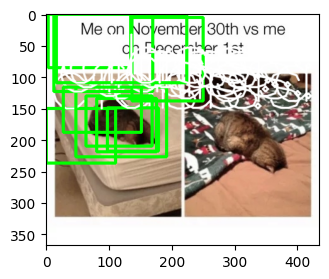

5807
['trump', 'on', 'january', '20th', 'when', 'mel', '##ania', 'leaves', 'his', 'ass', 'bum', '##ble', 'done', 'don', '32', 'pot', '##us', 'location', 'washington', 'dc', 'i', 'love', 'and', 'respect', 'all', 'women', 'favorite', 'song', 'wonder', '##wall']


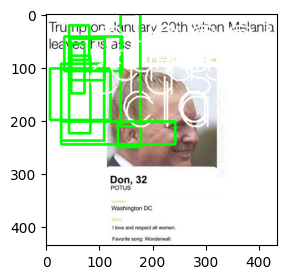

1321
['random', 'person', 'gives', 'me', 'a', 'compliment', 'me', 'the', 'rest', 'of', 'the', 'day']


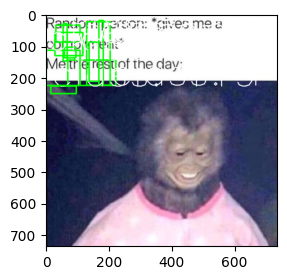

1774
['when', 'your', '##e', 'walking', 'down', 'a', 'hall', 'and', 'walk', 'past', 'your', 'best', 'friends', 'class']


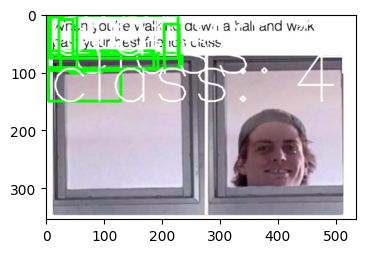

2876
['me', 'when', 'i', 'hear', 'my', 'senator', 'isn', '##t', 'gonna', 'vote', 'for', 'the', 'for', 'the', 'people', 'act']


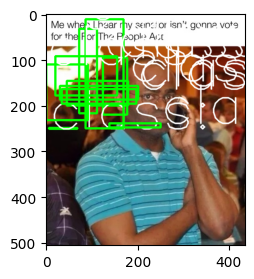

3863
['someone', 'commented', 'that', 'donald', 'trump', 'stands', 'like', 'a', 'cent', '##aur', 'without', 'its', 'hind', 'legs', 'and', 'now', 'lc', '##ant', 'un', '##see', 'it', 'school', '##ey', 'first', 'day', 'of', 'standing', 'lessons', 'show', 'this']


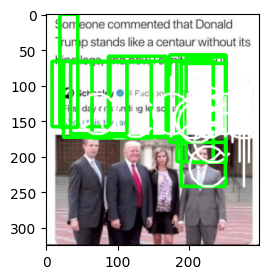

6880
['everyone', 'how', '##s', 'life', 'going', 'me']


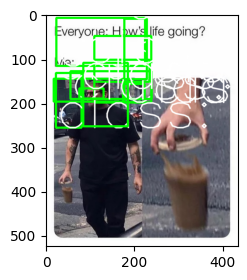

5547
['me', 'i', 'haven', '##t', 'eaten', 'all', 'day', 'my', 'grandma']


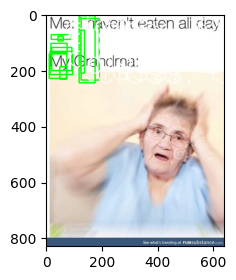

In [29]:
img_root_path = '../data/Memotion2.0/images/train_images'
batch_toks_ids = batch_toks['input_ids'].tolist()

topk = 10

for i in range(args.batch_size):
    sample_metadata = batch_metadata[i]
    sample_toks_ids = batch_toks_ids[i]
    sample_idx = batch_idx[i]
    
    img_path = os.path.join(img_root_path, sample_metadata['img_id'])
    img = plt.imread(img_path)

    boxes = np.array(sample_metadata['boxes'])
    categories = np.array(sample_metadata['objects_id'])
    confidences = np.array(sample_metadata['objects_conf'])
    topboxes_idx = np.flip(np.argsort(confidences))[:topk]
    

    topboxes = boxes[topboxes_idx]
    topconfidences = confidences[topboxes_idx]
    topcategories = categories[topboxes_idx]


    for i in range(topk):
        # x1, y1, x2, y2
        box = topboxes[i].astype(np.uint8)
        confidence = topconfidences[i]
        category = topcategories[i]

        # print(box)
        
        cv.rectangle(img,(box[0],box[1]),(box[2],box[3]),(0,255,0),3)

        font = cv.FONT_HERSHEY_SIMPLEX
        cv.putText(img, f'class: {category} prob: {confidence}', (box[0],box[1]), font, 4,(255,255,255),2,cv.LINE_AA)

        # print(box)
        # print(confidence)
        # print(category)
    
    sample_toks = tokenizer.convert_ids_to_tokens(sample_toks_ids, skip_special_tokens=True)

    print(sample_idx)
    print(sample_toks)
    plt.figure(figsize=(4, 3))
    plt.imshow(img)

    plt.show()